# Setup

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import tqdm
from scipy.stats import norm, lognorm, gamma, invgamma, burr12

Next block helps bypass folium display problems on VS Code, got this code from here: https://github.com/microsoft/vscode-jupyter/issues/17224#issuecomment-3679624559

In [2]:
from folium import Map
import base64
from IPython.display import IFrame, display

def show_folium_safe(m : Map, height=500):
    """
    Displays a Folium map in a safe IFrame using Base64 encoding.
    This avoids "Trusted" errors, file path issues, and CSS leakage.
    """
    # 1. Get the raw HTML string of the map
    html_content = m.get_root().render()
    
    # 2. Encode the HTML to base64
    # This allows us to put the entire map "inside" the URL string
    encoded = base64.b64encode(html_content.encode('utf-8')).decode('utf-8')
    
    # 3. Create a Data URI
    data_uri = f"data:text/html;charset=utf-8;base64,{encoded}"
    
    # 4. Display the IFrame
    # We use width='100%' to fill the cell width, but the CSS is trapped inside
    display(IFrame(src=data_uri, width="100%", height=height))

### Network downloads with OSMNx

In [3]:
# # Test Graph

# testGraph = ox.graph.graph_from_point((38.539078, -121.752065), dist=250, network_type='bike')
# fig, ax = ox.plot.plot_graph(testGraph)

# # Save the graph for offline access
# ox.io.save_graphml(testGraph, "testGraph.graphml")

In [4]:
# # Bounding box for the full Davis network
# bbox = (-121.794484891,38.5235690581,-121.6752063856,38.5755508478)

In [5]:
# # Bike Network Graph
# bikeGraph = ox.graph.graph_from_bbox(bbox, network_type='bike')
# fig, ax = ox.plot.plot_graph(bikeGraph)

# # Save the graph for offline access
# ox.io.save_graphml(bikeGraph, "bikeGraph.graphml")

In [6]:
# # Driving Network Graph
# driveGraph = ox.graph.graph_from_bbox(bbox, network_type='drive')
# fig, ax = ox.plot.plot_graph(driveGraph)

# # Save the graph for offline access
# ox.io.save_graphml(driveGraph, "driveGraph.graphml")

### Bike Network

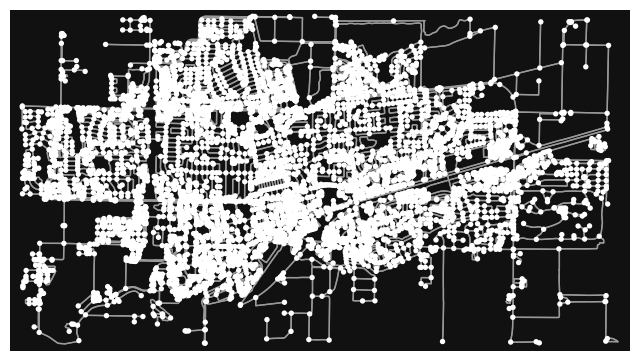

In [7]:
bikeGraph = ox.io.load_graphml("bikeGraph.graphml")
bikeGraph = ox.routing.add_edge_speeds(bikeGraph)
bikeGraph = ox.routing.add_edge_travel_times(bikeGraph)
bikeNodes, bikeEdges = ox.graph_to_gdfs(bikeGraph)
fig, ax = ox.plot.plot_graph(bikeGraph)

### Driving Network

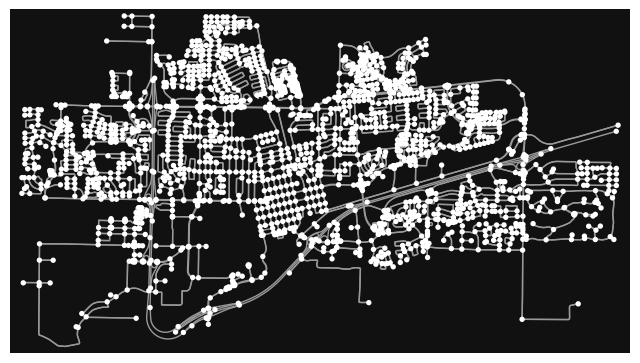

In [8]:
driveGraph = ox.io.load_graphml("driveGraph.graphml")
driveGraph = ox.routing.add_edge_speeds(driveGraph,
                                        hwy_speeds = {"motorway": 104.6,      # 65 mph in kph
                                                      "motorway_link": 72.4,  # 45 mph in kph
                                                      "primary": 72.4,        # 45 mph in kph
                                                      "primary_link": 24.1,   # 15 mph in kph
                                                      "secondary": 56.3,      # 35 mph in kph
                                                      "secondary_link": 24.1, # 15 mph in kph
                                                      "tertiary": 56.3,       # 35 mph in kph
                                                      "residential": 40.2,    # 25 mph in kph
                                                      "unclassified": 40.2,   # 25 mph in kph
                                                      "busway": 40.2,         # 25 mph in kph
                                                      })
driveGraph = ox.routing.add_edge_travel_times(driveGraph)
driveNodes, driveEdges = ox.convert.graph_to_gdfs(driveGraph)
fig, ax = ox.plot.plot_graph(driveGraph)

### Test Graph

In [10]:
testGraph = ox.io.load_graphml("testGraph.graphml")
testGraph = ox.routing.add_edge_speeds(testGraph)
testGraph = ox.routing.add_edge_travel_times(testGraph)
testNodes, testEdges = ox.graph_to_gdfs(testGraph)

# Clean bike network and testing

### Empirical bike speed data

In [11]:
# Read bike speed data
bikeSpeeds = pd.read_excel("Bike Speeds.xlsx")
bikeSpeeds = bikeSpeeds.set_index('Speed (mph)')
bikeSpeeds["Speed (m/s)"] = bikeSpeeds.index * 0.44704
bikeSpeeds

,2026-01-22 00:00:00,2026-01-23 00:00:00,2026-01-24 00:00:00,2026-01-25 00:00:00,2026-01-26 00:00:00,2026-01-27 00:00:00,2026-01-28 00:00:00,Total,Speed (m/s)
Speed (mph),,,,,,,,,
1,0,0,0,0,1,0,0,1,0.44704
2,1,1,0,0,3,2,0,7,0.89408
3,4,5,3,0,2,0,4,18,1.34112
4,3,4,2,0,2,8,7,26,1.78816
5,8,8,1,4,8,6,6,41,2.23520
6,24,23,6,10,20,18,22,123,2.68224
7,40,63,16,15,43,49,39,265,3.12928
8,120,122,43,42,110,118,128,683,3.57632
9,171,199,66,61,194,213,220,1124,4.02336


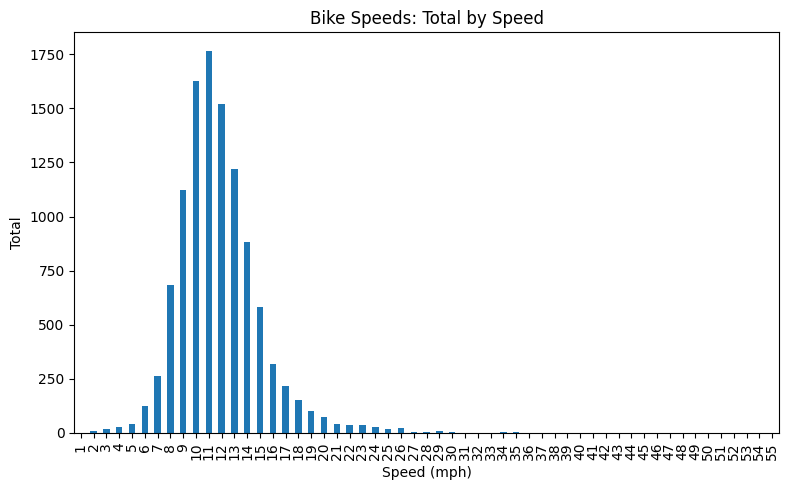

In [12]:
# Plot bike speed data
fig, ax = plt.subplots(figsize=(8, 5))
bikeSpeeds["Total"].plot(kind="bar", ax=ax)
ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Total")
ax.set_title("Bike Speeds: Total by Speed")
plt.tight_layout()
plt.show()

### Testing fitting distribution for one edge

In [13]:
# Calculate travel time samples based on the bike speed data
speeds_ms = bikeSpeeds["Speed (m/s)"].to_numpy()
counts = bikeSpeeds["Total"].to_numpy().astype(int)
speeds_ms_expanded = np.repeat(speeds_ms, counts)
tt_sample = testEdges["length"].iloc[0] / speeds_ms_expanded # test edge

gamma_params = gamma.fit(tt_sample, floc=0)
norm_params = norm.fit(tt_sample)
lognorm_params = lognorm.fit(tt_sample, floc=0)
invgamma_params = invgamma.fit(tt_sample, floc=0)
burr12_params = burr12.fit(tt_sample, floc=0)

In [14]:
gamma_params

(13.083137407169803, 0, np.float64(1.1585641599697638))

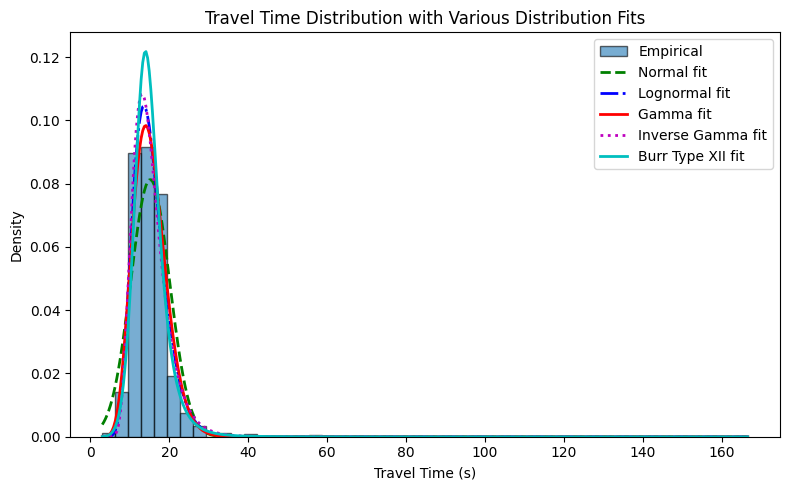

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(tt_sample, bins=50, density=True, edgecolor="black", alpha=0.6, label="Empirical")

x = np.linspace(tt_sample.min(), tt_sample.max(), 400)
ax.plot(x, norm.pdf(x, *norm_params), "g--", linewidth=2, label="Normal fit")
ax.plot(x, lognorm.pdf(x, *lognorm_params), "b-.", linewidth=2, label="Lognormal fit")
ax.plot(x, gamma.pdf(x, *gamma_params), "r-", linewidth=2, label="Gamma fit")
ax.plot(x, invgamma.pdf(x, *invgamma_params), "m:", linewidth=2, label="Inverse Gamma fit")
ax.plot(x, burr12.pdf(x, *burr12_params), "c-", linewidth=2, label="Burr Type XII fit")

ax.set_xlabel("Travel Time (s)")
ax.set_ylabel("Density")
ax.set_title("Travel Time Distribution with Various Distribution Fits")
ax.legend()
plt.tight_layout()
plt.show()

Gamma distribution seems to be best for fitting the speed distributions. Initially the speed data was gamma distributed, so I expected the travel time distribution to follow an inverse gamma distribution. Howver, this doesn't seem to be the case given the test case.

### Fitting gamma travel time distributions for all edges

In [16]:
def computeBikeGammaParams(edges, speeds_ms_expanded):
    gamma_params_list = []
    for index, row in edges.iterrows():
        tt_distribution = row["length"] / speeds_ms_expanded  # calculate travel times for this edge with empirical speed data
        gamma_params = gamma.fit(tt_distribution, floc=0)
        gamma_params_list.append(gamma_params)
    edges['gamma_params'] = gamma_params_list
    return edges

In [17]:
# Create expanded speed samples
speeds_ms = bikeSpeeds["Speed (m/s)"].to_numpy()
counts = bikeSpeeds["Total"].to_numpy().astype(int)
speeds_ms_expanded = np.repeat(speeds_ms, counts)

# Calculate gamma parameters for all edges
testEdges = computeBikeGammaParams(testEdges, speeds_ms_expanded)
bikeEdges = computeBikeGammaParams(bikeEdges, speeds_ms_expanded)

# Clean car network and testing

We don't have empirical speed data for cars, but assumptions will be made using the mean travel time values calculated by OSMNx and with dispersions dependent on road type.

In [18]:
driveEdges["highway"].value_counts()

highway
residential                    3477
tertiary                        854
secondary                       348
primary                          86
motorway_link                    53
secondary_link                   31
primary_link                     30
motorway                         29
unclassified                     16
tertiary_link                     6
[tertiary, residential]           4
[unclassified, residential]       2
[tertiary, secondary]             1
busway                            1
Name: count, dtype: int64

In [19]:
driveEdges["Speed (m/s)"] = driveEdges["speed_kph"] / 3.6

Dispersions come from Berry and Belmont (1951). In the paper, the normalized standard deviation is normalized by the median rather than the mean, but here we don't have median speeds so we just assume that the speeds used (derived from max speeds and values given through the hwy_speeds argument) are median speeds.

In [20]:
def findDriveStddev(speed, type):
    # Check for list first
    if isinstance(type, list):
        type = type[-1]  # If it's a list, take the last element which gives the smaller street
    
    # Check the type and assign standard deviation as a percentage of the speed
    if type in ["motorway"]:
        std_dev = speed * 0.13  # Assume 13% standard deviation for motorways, using four-lane divided highway as reference
    elif type in ["motorway_link"]:
        std_dev = speed * 0.15  # Assume 15% standard deviation for motorway links, arbitrary
    elif type in ["primary"]:
        std_dev = speed * 0.22  # Assume 22% standard deviation for primary roads, using 40 mph zone as reference
    elif type in ["secondary", "tertiary"]:
        std_dev = speed * 0.15  # Assume 15% standard deviation for secondary roads, using two-lane through street as reference
    elif type in ["primary_link", "secondary_link", "tertiary_link"]:
        std_dev = speed * 0.25  # Assume 25% standard deviation for primary/secondary/tertiary links, arbitrary
    elif type in ["residential", "unclassified", "busway"]:
        std_dev = speed * 0.13  # Assume 13% standard deviation for residential roads, using two-lane suburban street as reference
    return std_dev

It will be assumed that the calculated speeds from max speeds are the 85th percentile speeds. Using this information and the assumed standard deviation values, we calculate the mean and sample those speeds to create the speed distribution. Congestion conditions are modeled by increasing the standard deviation by 25% and assuming that the calculated speeds are 95th percentile speeds instead--essentially significantly reducing the mean traffic speed.



In [21]:
from scipy import stats

def sampleSpeeds(edge, congestion=False):
    speed = edge["Speed (m/s)"]
    std_dev = findDriveStddev(speed, edge["highway"])
    if congestion is False:
        mean_speed = speed - stats.norm.ppf(0.85) * std_dev
    else:
        std_dev = std_dev * 1.25                                                # Increase standard deviation to reflect more variability in congested conditions, arbitrary
        mean_speed = speed - stats.norm.ppf(0.95) * std_dev
    np.random.seed(0)                                                           # Set seed for reproducibility
    speed_samples = np.random.normal(loc=mean_speed, scale=std_dev, size=10000) # Sample speeds from a normal distribution
    speed_samples = np.clip(speed_samples, min=1.0, max=None)                   # clip values that are below 1.0 to avoid dividing by 0 or non-negative speeds
    return speed_samples

Example of using these functions on the first edge to make a speed distribution for both non-congested and congested conditions

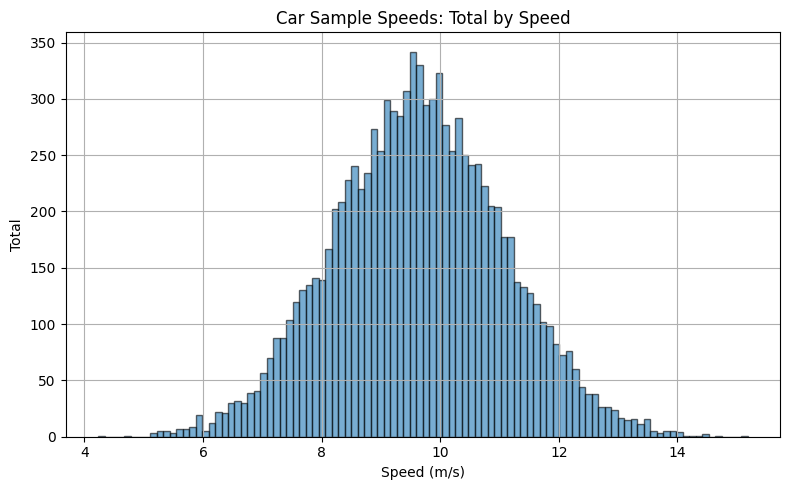

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame(sampleSpeeds(driveEdges.iloc[0])).hist(ax=ax, bins=100, edgecolor="black", alpha=0.6)
ax.set_xlabel("Speed (m/s)")
ax.set_ylabel("Total")
ax.set_title("Car Sample Speeds: Total by Speed")
plt.tight_layout()
plt.show()

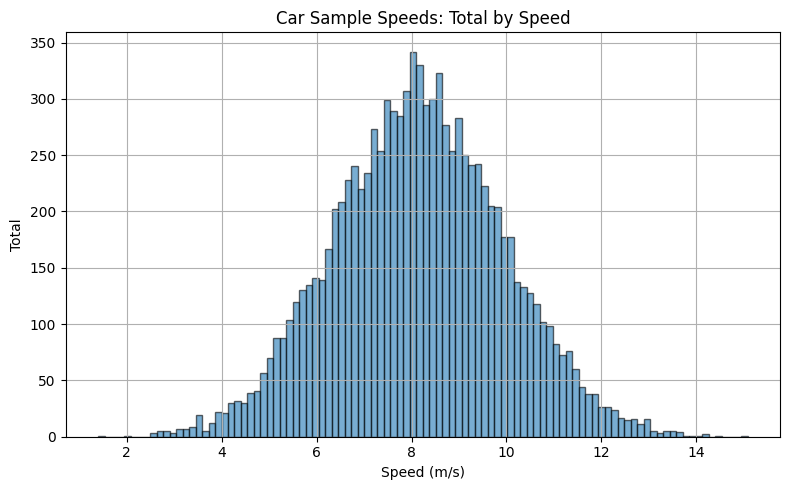

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame(sampleSpeeds(driveEdges.iloc[0], congestion=True)).hist(ax=ax, bins=100, edgecolor="black", alpha=0.6)
ax.set_xlabel("Speed (m/s)")
ax.set_ylabel("Total")
ax.set_title("Car Sample Speeds: Total by Speed")
plt.tight_layout()
plt.show()

Creating a travel time distribution using the speed distribution

In [24]:
driveTT_sample = driveEdges.iloc[0]["length"] / sampleSpeeds(driveEdges.iloc[0])

gamma_params = gamma.fit(driveTT_sample, floc=0)
norm_params = norm.fit(driveTT_sample)
lognorm_params = lognorm.fit(driveTT_sample, floc=0)
invgamma_params = invgamma.fit(driveTT_sample, floc=0)
burr12_params = burr12.fit(driveTT_sample, floc=0)

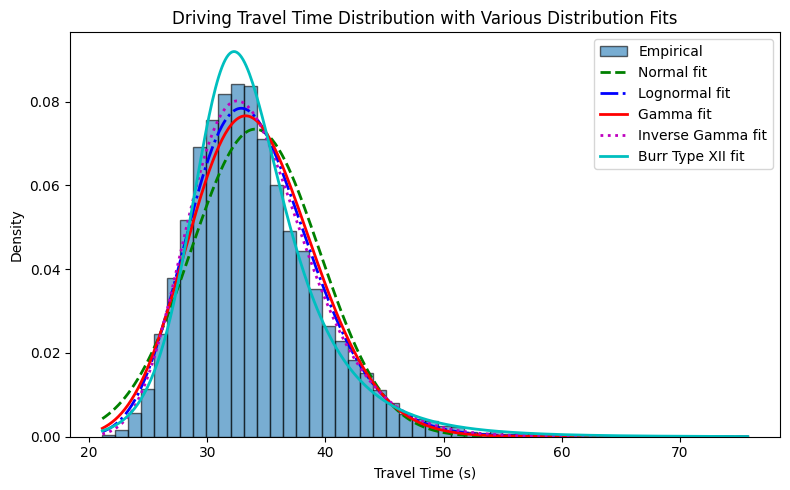

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(driveTT_sample, bins=50, density=True, edgecolor="black", alpha=0.6, label="Empirical")

x = np.linspace(driveTT_sample.min(), driveTT_sample.max(), 400)
ax.plot(x, norm.pdf(x, *norm_params), "g--", linewidth=2, label="Normal fit")
ax.plot(x, lognorm.pdf(x, *lognorm_params), "b-.", linewidth=2, label="Lognormal fit")
ax.plot(x, gamma.pdf(x, *gamma_params), "r-", linewidth=2, label="Gamma fit")
ax.plot(x, invgamma.pdf(x, *invgamma_params), "m:", linewidth=2, label="Inverse Gamma fit")
ax.plot(x, burr12.pdf(x, *burr12_params), "c-", linewidth=2, label="Burr Type XII fit")

ax.set_xlabel("Travel Time (s)")
ax.set_ylabel("Density")
ax.set_title("Driving Travel Time Distribution with Various Distribution Fits")
ax.legend()
plt.tight_layout()
plt.show()

Compute parameters for each edge--gamma distribution runs significantly faster so we're just going to choose that LMAO

In [26]:
# def computeCarBurrParams(edges):
#     burr_params_list = []
#     for i in tqdm.tqdm(range(len(edges))):
#         tt_distribution = edges.iloc[i]["length"] / sampleSpeeds(edges.iloc[i])  # calculate travel times for this edge with empirical speed data
#         burr_params = burr12.fit(tt_distribution, floc=0)
#         burr_params_list.append(burr_params)
#     edges['burr_params'] = burr_params_list
#     return edges

In [27]:
# test = computeCarBurrParams(driveEdges)

In [28]:
def computeCarGammaParams(edges):
    gamma_params_list = []
    gamma_params_congested_list = []
    for i in tqdm.tqdm(range(len(edges))):
        tt_distribution = edges.iloc[i]["length"] / sampleSpeeds(edges.iloc[i], congestion = False)             # travel times without congestion
        tt_distribution_congested = edges.iloc[i]["length"] / sampleSpeeds(edges.iloc[i], congestion = True)    # travel times with congestion
        
        gamma_params = gamma.fit(tt_distribution, floc=0)
        gamma_params_congested = gamma.fit(tt_distribution_congested, floc=0)
        
        gamma_params_list.append(gamma_params)
        gamma_params_congested_list.append(gamma_params_congested)
    edges['gamma_params'] = gamma_params_list
    edges['gamma_params_c'] = gamma_params_congested_list
    return edges

In [29]:
driveEdges = computeCarGammaParams(driveEdges)

100%|██████████| 4938/4938 [00:04<00:00, 1195.48it/s]


# Create Travel Time Distributions

In [30]:
def TTDistribution(edges, timeBudget, interval, congestion = False):
    # Calculate the number of intervals based on the time budget and interval size
    maxInterval = int(timeBudget / interval)
    # Create a time range from 0 to timeBudget with the specified interval
    x = np.linspace(0, timeBudget, maxInterval + 1)
    
    # Based on time range and interval, create travel time distributions for each edge using the gamma params
    output = pd.DataFrame(
        index=edges.index,
        columns=np.arange(0, maxInterval + 1)
    )

    for index, row in edges.iterrows():
        if congestion is False:
            gamma_params = row["gamma_params"]          # access gamma parameters for the edge
        else:
            gamma_params = row["gamma_params_c"]
        distribution = gamma.pdf(x, *gamma_params)  # create gamma distribution PDF values over the time range
        pdf_values = distribution * interval        # scale by time unit for discretization

        # Store the PDF values in the TTDistribution column
        output.loc[index] = pdf_values
    
    return output.astype(np.float64)

## Bike Distributions

### Initial Creation

In [31]:
testDistributions = TTDistribution(testEdges, 300, 1)
bikeDistributions = TTDistribution(bikeEdges, 1200, 1)

In [32]:
testDistributions

0             1             2             3    \
u           v           key                                                  
95712770    277046658   0    0.0  1.040419e-10  1.904317e-07  1.077999e-05   
            273245111   0    0.0  3.500148e-09  4.786298e-06  2.024236e-04   
            273245096   0    0.0  5.178901e-13  1.280448e-09  9.791170e-08   
            9159686623  0    0.0  5.050371e-13  1.250079e-09  9.569733e-08   
95716931    559373141   0    0.0  9.039187e-11  1.670891e-07  9.552454e-06   
...                          ...           ...           ...           ...   
10684990793 639324548   0    0.0  5.842001e-05  1.635711e-02  1.416444e-01   
            10684990777 0    0.0  2.333865e-12  5.369045e-09  3.820027e-07   
10684990794 10684990793 0    0.0  1.164284e-03  1.236831e-01  4.063587e-01   
            272014000   0    0.0  8.355000e-10  1.301106e-06  6.266524e-05   
            5674111324  0    0.0  7.398989e-14  1.983114e-10  1.643884e-08   

                                      4         5         6         7    \
u           v           key                                               
95712770    277046658   0    1.470329e-04  0.000919  0.003511  0.009539   
            273245111   0    2.062717e-03  0.009637  0.027493  0.055806   
            273245096   0    1.803949e-06  0.000015  0.000079  0.000288   
            9159686623  0    1.765140e-06  0.000015  0.000077  0.000283   
95716931    559373141   0    1.315827e-04  0.000831  0.003205  0.008793   
...                                   ...       ...       ...       ...   
10684990793 639324548   0    2.955352e-01  0.282712  0.165143  0.068635   
            10684990777 0    6.548666e-06  0.000051  0.000247  0.000844   
10684990794 10684990793 0    3.216814e-01  0.116753  0.025876  0.004080   
            272014000   0    7.272068e-04  0.003869  0.012570  0.029057   
            5674111324  0    3.283308e-07  0.000003  0.000017  0.000067   

                                  8         9    ...            291  \
u           v           key                      ...                  
95712770    277046658   0    0.020201  0.035368  ...   1.203891e-89   
            273245111   0    0.088294  0.115489  ...  7.732859e-125   
            273245096   0    0.000825  0.001952  ...   4.463888e-54   
            9159686623  0    0.000811  0.001920  ...   6.037119e-54   
95716931    559373141   0    0.018807  0.033253  ...   1.832119e-88   
...                               ...       ...  ...            ...   
10684990793 639324548   0    0.022235  0.005955  ...  2.332978e-320   
            10684990777 0    0.002245  0.004941  ...   1.681307e-62   
10684990794 10684990793 0    0.000501  0.000051  ...   0.000000e+00   
            272014000   0    0.052355  0.077987  ...  4.340090e-109   
            5674111324  0    0.000207  0.000532  ...   9.319690e-45   

                                       292            293            294  \
u           v           key                                                
95712770    277046658   0     5.293386e-90   2.327118e-90   1.022921e-90   
            273245111   0    2.540205e-125  8.343265e-126  2.739947e-126   
            273245096   0     2.651265e-54   1.574459e-54   9.348644e-55   
            9159686623  0     3.589710e-54   2.134162e-54   1.268628e-54   
95716931    559373141   0     8.135568e-89   3.612106e-89   1.603511e-89   
...                                    ...            ...            ...   
10684990793 639324548   0    1.571129e-321  1.086944e-322  1.482197e-323   
            10684990777 0     9.291455e-63   5.134036e-63   2.836436e-63   
10684990794 10684990793 0     0.000000e+00   0.000000e+00   0.000000e+00   
            272014000   0    1.623604e-109  6.072957e-110  2.271219e-110   
            5674111324  0     6.000566e-45   3.862970e-45   2.486506e-45   

                                       295            296            297  \
u           v           key                      

In [33]:
bikeDistributions

0             1             2             3     \
u           v           key                                                   
27043369    3936279440  0     0.0  1.017052e+00  3.627381e-04  4.001209e-09   
62209051    390372817   0     0.0  9.794414e-27  4.049324e-23  5.177672e-21   
62209053    62272114    0     0.0  1.983912e-18  6.970297e-15  7.574053e-13   
62209073    62258814    0     0.0  4.997824e-19  1.793957e-15  1.991549e-13   
62209094    62225084    0     0.0  2.011416e-13  5.180467e-10  4.126521e-08   
...                           ...           ...           ...           ...   
13439947683 1901852695  0     0.0  1.453474e-05  5.715230e-03  6.950375e-02   
            10216918922 0     0.0  6.607575e-05  1.790226e-02  1.500105e-01   
13439947684 1901852707  0     0.0  2.111766e-01  6.713941e-01  6.601722e-02   
            8434494012  0     0.0  2.210891e-10  3.829949e-07  2.051950e-05   
            13439947683 0     0.0  8.862865e-10  1.373272e-06  6.580930e-05   

                                     4             5             6     \
u           v           key                                             
27043369    3936279440  0    1.063424e-14  1.295826e-20  9.642012e-27   
62209051    390372817   0    1.595158e-19  2.253191e-18  1.943448e-17   
62209053    62272114    0    1.982999e-11  2.380354e-10  1.744784e-09   
62209073    62258814    0    5.327054e-12  6.532934e-11  4.892269e-10   
62209094    62225084    0    7.919836e-07  6.969047e-06  3.744653e-05   
...                                   ...           ...           ...   
13439947683 1901852695  0    2.036572e-01  2.736002e-01  2.244470e-01   
            10216918922 0    3.028673e-01  2.803549e-01  1.584692e-01   
13439947684 1901852707  0    1.564062e-03  1.698931e-05  1.126882e-07   
            8434494012  0    2.648851e-04  1.567737e-03  5.665914e-03   
            13439947683 0    7.598623e-04  4.022607e-03  1.300353e-02   

                                     7             8             9     ...  \
u           v           key                                            ...   
27043369    3936279440  0    5.104558e-33  2.106425e-39  7.186083e-46  ...   
62209051    390372817   0    1.192662e-16  5.705049e-16  2.256106e-15  ...   
62209053    62272114    0    9.099363e-09  3.698944e-08  1.243091e-07  ...   
62209073    62258814    0    2.606644e-09  1.082557e-08  3.716873e-08  ...   
62209094    62225084    0    1.431591e-04  4.266030e-04  1.050962e-03  ...   
...                                   ...           ...           ...  ...   
13439947683 1901852695  0    1.310028e-01  5.959982e-02  2.241649e-02  ...   
            10216918922 0    6.373105e-02  1.997812e-02  5.177456e-03  ...   
13439947684 1901852707  0    5.318028e-10  1.956231e-12  5.949054e-15  ...   
            8434494012  0    1.456921e-02  2.920113e-02  4.838618e-02  ...   
            13439947683 0    2.990778e-02  5.361725e-02  7.946635e-02  ...   

                                      1191           1192           1193  \
u           v           key                                                
27043369    3936279440  0     0.000000e+00   0.000000e+00   0.000000e+00   
62209051    390372817   0     1.542166e-14   1.484406e-14   1.428797e-14   
62209053    62272114    0     2.462321e-90   2.014147e-90   1.647532e-90   
62209073    62258814    0     7.278046e-80   6.082235e-80   5.082857e-80   
62209094    62225084    0    8.159103e-246  4.892456e-246  2.933646e-246   
...                                    ...            ...            ...   
13439947683 1901852695  0     0.000000e+00   0.000000e+00   0.000000e+00   
            10216918922 0     0.000000e+00   0.000000e+00   0.000000e+00   
13439947684 1901852707  0     0.000000e+00   0.000000e+00   0.000000e+00   
            8434494012  0     0.000000e+00   0.000000e+00   0.000000e+00   
            13439947683 0     0.000000e+00   0.000000e+00   0.000000e+00   

                                      1194     

### Distributions not summing to 1

In [34]:
testSums = testDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
testEdges["sums"] = testSums

In [35]:
bikeSums = bikeDistributions.sum(axis=1)
bikeEdges["sums"] = bikeSums

Because of some edges with short lengths, some distributions are summing to significantly above or below 0. This section here remedies this problem by identifying flawed distributions and replacing them with a uniform distribution for simplicity. The threshold used is a distribution summing to more than 1.001 or less than 0.999, in other words abs(error) > 0.001.

It seems that some errors in the bike network are also for very long edges. This is rare, but still needs to be addressed.

In [36]:
testErrors = testSums[abs(1 - testSums) > 0.001]
testSums[testErrors.index]

u           v           key
95716931    9147059880  0      0.953182
272013500   9147072726  0      1.001405
272013998   5598405315  0      1.237157
272026503   3942417569  0      1.002274
277046566   277046567   0      0.960356
            365656292   0      0.990624
277046567   277046566   0      0.960356
            365656292   0      0.980717
359390889   518293125   0      0.979537
365656292   277046566   0      0.990624
            277046567   0      0.980717
518293125   359390889   0      0.979537
559262556   3942353072  0      1.415586
559262563   9147072726  0      0.460075
3942353072  559262556   0      1.415586
3942353104  3942353116  0      0.969505
3942353112  3942353131  0      1.447575
3942353115  3942353112  0      0.986121
3942353116  3942353115  0      1.221402
3942353119  3942353104  0      0.865075
3942353123  3942353119  0      0.996484
3942353130  3942353123  0      1.206467
3942353131  3942353130  0      0.980519
3942353142  3942353153  0      0.986196
3942353144  

In [37]:
bikeErrors = bikeSums[abs(1 - bikeSums) > 0.001]
bikeSums[bikeErrors.index]

u            v           key
27043369     3936279440  0      1.017415
95704000     3568619598  0      1.109527
95704047     2586285912  0      1.447506
95706162     7010408187  0      0.965765
             95715668    0      0.969566
                                  ...   
13382675826  1918174692  0      0.979788
13385642172  2590587331  0      0.993585
13439947674  1901852690  0      1.220666
13439947683  1901852705  0      0.936822
13439947684  1901852707  0      0.950169
Length: 2518, dtype: float64

After investigating the actual travel time distributions, it's clear that these edges are so short that the chosen interval of 1 second isn't suitable to properly capture a proper probability distribution function, leading to these errors. Checking the edge lengths and travel times shows the same thing.

In [38]:
testEdges.loc[testErrors.index, ["length","travel_time", "gamma_params", "sums"]].sort_values("travel_time")

,,,length,travel_time,gamma_params,sums
u,v,key,,,,
3942697369,3942441826,0,2.345082,0.349721,"(13.083137407169854, 0, 0.03649537007047889)",0.013765
3942441819,3942697375,0,2.392964,0.356861,"(13.083137407169854, 0, 0.03724053246434274)",0.018283
3942417576,3942417578,0,2.694859,0.401883,"(13.083137407169803, 0, 0.041938772765665454)",0.078236
3942697374,3942697373,0,2.901474,0.432695,"(13.083137407169767, 0, 0.0451542209413805)",0.162585
3942353153,3942353155,0,3.260067,0.486172,"(13.083137407169803, 0, 0.0507348418963065)",0.404498
3942417567,3942417562,0,3.307056,0.493179,"(13.083137407169854, 0, 0.05146609988945413)",0.443847
9147072726,559262563,0,3.325983,0.496002,"(13.083137407169854, 0, 0.05176066110914518)",0.460075
559262563,9147072726,0,3.325983,0.496002,"(13.083137407169854, 0, 0.05176066110914518)",0.460075
3942353119,3942353104,0,3.765557,0.561556,"(13.083137407169781, 0, 0.058601534529322756)",0.865075


In [39]:
bikeEdges.loc[bikeErrors.index, ["length","travel_time", "gamma_params", "sums"]].sort_values("travel_time")

,,,length,travel_time,gamma_params,sums
u,v,key,,,,
5288518111,5288518117,0,1.052142,0.099120,"(13.083137407169803, 0, 0.016373976638898773)",1.173135e-12
5288518117,5288518111,0,1.052142,0.099120,"(13.083137407169803, 0, 0.016373976638898773)",1.173135e-12
8430761501,10000488026,0,1.052382,0.099142,"(13.083137407169854, 0, 0.016377708515845156)",1.186033e-12
10000488026,8430761501,0,1.052382,0.099142,"(13.083137407169854, 0, 0.016377708515845156)",1.186033e-12
95711146,9170620055,0,1.134490,0.106877,"(13.083137407169854, 0, 0.01765551132167434)",3.684738e-11
...,...,...,...,...,...,...
9147059900,9147059899,0,14.611985,3.268616,"(13.083137407169803, 0, 0.22739921694631168)",1.001382e+00
9166142756,3938976411,0,15.054687,3.367646,"(13.083137407169854, 0, 0.23428877344942753)",1.001044e+00
3938976411,9166142756,0,15.054687,3.367646,"(13.083137407169854, 0, 0.23428877344942753)",1.001044e+00


##### Visual error edges identification check

Good validation, all of the visually shorter edges are the ones with problematic distributions.

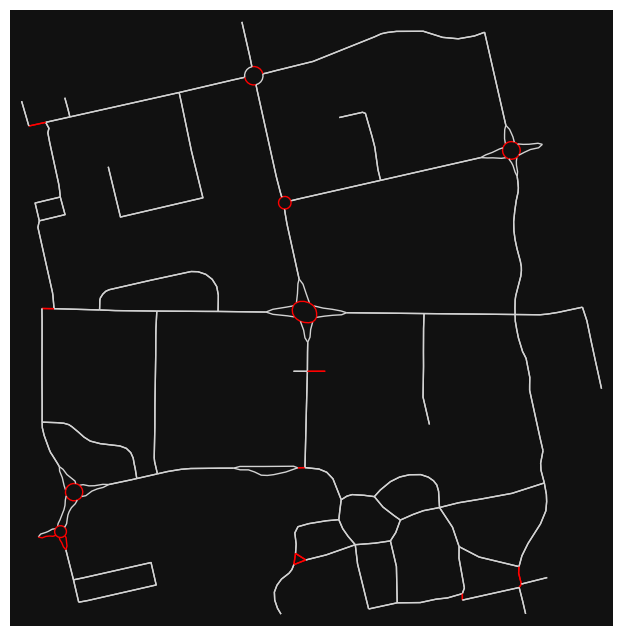

In [40]:
plotEdges = testEdges.copy()
plotEdges["color"] = np.where(plotEdges.index.isin(testErrors.index), 'red', 'lightgray')
plotGraph = ox.graph_from_gdfs(testNodes, plotEdges)

# Plotting edges with errors highlighted
fig, ax = ox.plot_graph(
    plotGraph,
    node_size=0,
    edge_color=plotEdges['color'],
    # linewidths argument is a mess so I'm just skipping it
    show=False,
    close=False,
)

plt.show()

##### Fixing the errors

To get rid of problematic distributions and simplify the graph, I'm just setting an arbitrary 100% chance for the nearest integer travel time when dividing by the average speed from bike speed data.

It shouldn't really affect the algorithm because of the low edge travel times relative to all the other edges--right now the biggest edges that we're setting with these arbitrary functions are at most around 3 seconds long.

In [41]:
def fixBikeShortEdges(edges, TTDistributions, meanSpeed, threshold=0.001):
    # This function identifies edges where the sum of the TT distribution is below a threshold and fixes them by assigning a uniform distribution
    sums = TTDistributions.sum(axis=1)
    errors = sums[abs(1 - sums) > threshold]
    edges["mean_travel_time"] = edges["length"] / meanSpeed

    # Assign a uniform distribution to error indices
    TTDistributions.loc[errors.index] = 0
    for index in errors.index:
        mean_travel_time = edges.loc[index, "mean_travel_time"]
        rounded_mean_travel_time = round(mean_travel_time)
        TTDistributions.loc[index, rounded_mean_travel_time] = np.float64(1)

    return TTDistributions

In [42]:
testDistributions = fixBikeShortEdges(testEdges, testDistributions, meanSpeed = speeds_ms_expanded.mean())
bikeDistributions = fixBikeShortEdges(bikeEdges, bikeDistributions, meanSpeed = speeds_ms_expanded.mean())

Check the new pdf sums, there should be no edges with a pdf sum with error more than 0.001

In [43]:
bikeSums = bikeDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
bikeEdges["sums"] = bikeSums
bikeSums[abs(1 - bikeSums) > 0.001]

Series([], dtype: float64)

## Car Distributions

In [44]:
driveDistributions = TTDistribution(driveEdges, 1200, 1)

In [45]:
congestedDriveDistributions = TTDistribution(driveEdges, 1200, 1, congestion=True)

### Distributions not summing to 1

In [46]:
driveSums = driveDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
driveEdges["sums"] = driveSums

In [47]:
congestedDriveSums = congestedDriveDistributions.sum(axis=1)
driveEdges["sums_c"] = congestedDriveSums

In [48]:
driveErrors = driveSums[abs(1 - driveSums) > 0.001]
driveSums[driveErrors.index]

u            v            key
62224679     5269745329   0      0.640304
             3313160878   0      2.135783
62372611     62372616     0      0.994732
62372616     62372611     0      0.994732
95704046     95720905     0      0.995366
                                   ...   
12557110164  498524143    0      2.136172
12959918036  12959918041  0      0.898788
12959918041  12959918036  0      0.898788
12959977179  12959977183  0      0.940910
12959977183  12959977179  0      0.940910
Length: 632, dtype: float64

In [49]:
congestedDriveErrors = congestedDriveSums[abs(1 - congestedDriveSums) > 0.001]
congestedDriveSums[congestedDriveErrors.index]

u            v            key
62224679     5269745329   0      0.987600
             3313160878   0      1.140231
95704196     95707123     0      0.996517
95707123     5727299821   0      1.236058
95708555     5201643328   0      0.448099
                                   ...   
12154768073  12154768070  0      0.605402
12477217141  95718342     0      0.989807
12557110162  12557110164  0      1.600325
12557110164  12557110162  0      1.600325
             498524143    0      1.141969
Length: 422, dtype: float64

In [50]:
driveEdges.loc[driveErrors.index, ["length","travel_time", "gamma_params", "sums"]].sort_values("travel_time")

,,,length,travel_time,gamma_params,sums
u,v,key,,,,
5874687860,5874687861,0,2.950044,0.188635,"(28.972576045274078, 0, 0.007998797668754247)",1.036472e-23
2581960385,2581960376,0,3.688372,0.235846,"(28.972576045273723, 0, 0.010000712463754493)",1.184822e-15
2581960309,2581960310,0,4.058639,0.259522,"(28.972576045273723, 0, 0.011004661401169508)",6.787772e-13
2581960303,2581960304,0,4.061565,0.259709,"(28.972576045273723, 0, 0.011012593753178677)",7.097199e-13
95715973,9005720511,0,3.605517,0.322882,"(41.97372106176093, 0, 0.009125979677496038)",3.498977e-12
...,...,...,...,...,...,...
95715562,4027192534,0,38.243179,3.424762,"(41.97372106176322, 0, 0.09679790086263029)",9.984137e-01
95722084,95722085,0,38.521607,3.449696,"(41.97372106176093, 0, 0.09750263665261956)",9.988254e-01
95722085,95722084,0,38.521607,3.449696,"(41.97372106176093, 0, 0.09750263665261956)",9.988254e-01


In [51]:
driveEdges.loc[congestedDriveErrors.index, ["length","travel_time", "gamma_params_c", "sums_c"]].sort_values("travel_time")

,,,length,travel_time,gamma_params_c,sums_c
u,v,key,,,,
5874687860,5874687861,0,2.950044,0.188635,"(9.816291799324961, 0, 0.03064660551644656)",0.000020
2581960385,2581960376,0,3.688372,0.235846,"(9.816291799325024, 0, 0.0383167448974643)",0.001551
2581960309,2581960310,0,4.058639,0.259522,"(9.816291799325024, 0, 0.04216327637853937)",0.006559
2581960303,2581960304,0,4.061565,0.259709,"(9.816291799325043, 0, 0.04219366840405485)",0.006625
95715973,9005720511,0,3.605517,0.322882,"(17.091300618162943, 0, 0.027371590612418832)",0.002571
...,...,...,...,...,...,...
2580278625,2580278630,0,165.676179,8.238042,"(1.65767504994187, 0, 15.063134996511453)",0.998061
366767948,2580278625,0,177.211003,8.811597,"(1.6576750499418742, 0, 16.111871238047517)",0.998265
599389931,2580285956,0,197.154149,9.803245,"(1.657675049941872, 0, 17.925084846757734)",0.998545


This code outputs driveMapTest.html which shows the edges with weird sums. Once again, short edges are the culprits, so they'll be set to a uniform distribution

In [52]:
# driveEdges["error"] = False
# driveEdges.loc[driveErrors.index, "error"] = True

In [53]:
# driveMapTest = driveEdges.explore(tiles = "cartodbpositron", column="error", cmap="inferno")
# driveMapTest.save("driveMapTest.html")

#### Fixing the distributions

In [54]:
def fixDriveShortEdges(edges, TTDistributions, threshold=0.001):
    # This function identifies edges where the sum of the TT distribution is below a threshold and fixes them by assigning a uniform distribution
    sums = TTDistributions.sum(axis=1)
    errors = sums[abs(1 - sums) > threshold]
    edges["mean_travel_time"] = edges["length"] / edges["Speed (m/s)"]

    # Assign a uniform distribution to error indices
    TTDistributions.loc[errors.index] = 0
    for index in errors.index:
        mean_travel_time = edges.loc[index, "mean_travel_time"]
        rounded_mean_travel_time = round(mean_travel_time)
        TTDistributions.loc[index, rounded_mean_travel_time] = np.float64(1)

    return TTDistributions

In [55]:
driveDistributions = fixDriveShortEdges(driveEdges, driveDistributions)

In [56]:
congestedDriveDistributions = fixDriveShortEdges(driveEdges, congestedDriveDistributions)

Check the distribution sums one last time

In [57]:
driveSums = driveDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
driveEdges["sums"] = driveSums
driveSums[abs(1 - driveSums) > 0.001]

Series([], dtype: float64)

In [58]:
congestedDriveSums = congestedDriveDistributions.sum(axis=1)
driveEdges["sums_c"] = congestedDriveSums
congestedDriveSums[abs(1 - congestedDriveSums) > 0.001]

Series([], dtype: float64)

# Algorithm

In [59]:
# Test endNode
testEndNode = 301036896
endNode = 288549656

### Original Code for single-thread processing

In [60]:
# Function to solve for probability and policy tables given an endNode, TTDistributions, timeBudget, and interval
# timeBudget and interval are created with TTDistributions above, do I want to pass them as part of TTDistributions?
def SOTAsolve(endNode, TTDistributions, timeBudget, interval, nodes, edges):
    # Recalculate maxInterval based on timeBudget and interval
    maxInterval = int(timeBudget / interval)
    
    # Initilize probability and policy tables
    initializeStart = time.time() # for timing how long initialization takes
    probabilities = pd.DataFrame(
        columns= np.arange(0, maxInterval + 1),
        index=nodes.index,
        dtype=np.float64
    )

    probabilities.index.names = ['Start node']
    probabilities.iloc[:,:] = 0.0
    probabilities.loc[endNode,] = 1.0
    
    policy = pd.DataFrame(
        columns= np.arange(0, maxInterval + 1),
        index=nodes.index,
    )
    policy.index.names = ['Start node']
    initializeEnd = time.time() # for timing how long initialization takes
    print(f"Time to initialize policy and probabilities: {initializeEnd - initializeStart} seconds")

    # Iterate through all time budgets and solve for optimal probabilities and policies
    algorithmStart = time.time() # for timing how long the algorithm takes
    for tb in tqdm.tqdm(np.arange(0, maxInterval + 1), unit=" iterations (time budgets)"):

        # Iterate through the possible start nodes
        for startNode in policy.index:

            # ignore endNode
            if startNode == endNode:
                continue

            # ignore nodes that can't be left from, a.k.a. it has no edges with it as a starting node
            if startNode not in edges.index.get_level_values("u"):
                probabilities.loc[startNode, tb] = 0.0
                policy.loc[startNode, tb] = np.nan
                continue

            # Calculate optimal probability of reaching the end node given the start node, end node, and time budget
            # Find relevant travel time distribution values
            distributionCalc = TTDistributions.loc[startNode].iloc[:,0:tb]
            # Reverse travel time distribution values matrix
            distributionCalc = distributionCalc.iloc[:, ::-1]
            # Find relevant probabilities to adjacent nodes
            adjacentNodes = distributionCalc.index
            # Create probabilitiesCalc DataFrame with MultiIndex to match distributionCalc
            endNodes = adjacentNodes.get_level_values("v")
            timeRange = range(0, tb)
            
            probabilitiesCalc = probabilities.loc[endNodes, timeRange].copy()
            probabilitiesCalc.index = adjacentNodes
            # Calculate the element-wise product of the two matrices
            result = distributionCalc.values * probabilitiesCalc.values
            # Sum the product to find probability of getting to end node based on which adjacent node is traveled to next
            row_sums = pd.Series(np.sum(result, axis=1), index=adjacentNodes)

            # Find the optimal probability, don't allow it to exceed 1
            probability = min(row_sums.max(), np.float64(1))
            # If we're approximately close to 1, just set it to 1 to avoid floating point issues
            if probability > 0.999:
                probability = np.float64(1)

            # Assign probability to the probability table
            probabilities.loc[startNode, tb] = probability
            
            # Store the optimal policy
            if np.nanmax(row_sums) == 0:
                policy.loc[startNode, tb] = np.nan
            else:
                policy.loc[startNode, tb] = str(row_sums.idxmax())
    
    algorithmEnd = time.time() # for timing how long the algorithm takes
    print(f"Time to run algorithm: {algorithmEnd - algorithmStart} seconds")

    # Return the probability and policy tables
    return probabilities, policy

### Multi-thread implementation

In [61]:
# def generateProbPolicy(startNode, endNode, TTDistributions, tb, edges, probabilities, policy):
#     # ignore endNode
#     if startNode == endNode:
#         return startNode, 1.0, np.nan

#     # ignore nodes that can't be left from, a.k.a. it has no edges with it as a starting node
#     if startNode not in edges.index.get_level_values("u"):
#         return startNode, 0.0, np.nan

#     # Calculate optimal probability of reaching the end node given the start node, end node, and time budget
#     # Find relevant travel time distribution values
#     distributionCalc = TTDistributions.loc[startNode].iloc[:,0:tb]
#     # Reverse travel time distribution values matrix
#     distributionCalc = distributionCalc.iloc[:, ::-1]
#     # Find relevant probabilities to adjacent nodes
#     adjacentNodes = distributionCalc.index
#     # Create probabilitiesCalc DataFrame with MultiIndex to match distributionCalc
#     endNodes = adjacentNodes.get_level_values("v")
#     timeRange = range(0, tb)
    
#     probabilitiesCalc = probabilities.loc[endNodes, timeRange].copy()
#     probabilitiesCalc.index = adjacentNodes
#     # Calculate the element-wise product of the two matrices
#     result = distributionCalc.values * probabilitiesCalc.values
#     # Sum the product to find probability of getting to end node based on which adjacent node is traveled to next
#     row_sums = pd.Series(np.sum(result, axis=1), index=adjacentNodes)

#     # Find the optimal probability, don't allow it to exceed 1
#     optimalProbability = min(row_sums.max(), np.float64(1))
#     # If we're approximately close to 1, just set it to 1 to avoid floating point issues
#     if optimalProbability > 0.999:
#         optimalProbability = np.float64(1)
    
#     # Store the optimal policy
#     if np.nanmax(row_sums) == 0:
#         optimalPolicy = np.nan
#     else:
#         optimalPolicy = str(row_sums.idxmax())

#     return startNode, optimalProbability, optimalPolicy

In [62]:
# import concurrent.futures

# # Function to solve for probability and policy tables given an endNode, TTDistributions, timeBudget, and interval
# # timeBudget and interval are created with TTDistributions above, do I want to pass them as part of TTDistributions?
# def SOTAsolveConcurrent(endNode, TTDistributions, timeBudget, interval, nodes, edges):
#     # Recalculate maxInterval based on timeBudget and interval
#     maxInterval = int(timeBudget / interval)
    
#     # Initilize probability and policy tables
#     initializeStart = time.time() # for timing how long initialization takes
#     probabilities = pd.DataFrame(
#         columns= np.arange(0, maxInterval + 1),
#         index=nodes.index,
#         dtype=np.float64
#     )

#     probabilities.index.names = ['Start node']
#     probabilities.iloc[:,:] = 0.0
#     probabilities.loc[endNode,] = 1.0
    
#     policy = pd.DataFrame(
#         columns= np.arange(0, maxInterval + 1),
#         index=nodes.index,
#     )
#     policy.index.names = ['Start node']
#     initializeEnd = time.time() # for timing how long initialization takes
#     print(f"Time to initialize policy and probabilities: {initializeEnd - initializeStart} seconds")

#     # Iterate through all time budgets and solve for optimal probabilities and policies
#     algorithmStart = time.time() # for timing how long the algorithm takes
#     for tb in tqdm.tqdm(np.arange(0, maxInterval + 1), unit=" iterations (time budgets)"):
        
#         # Use multithreading to calculate probabilities and policies for all start nodes in parallel for this time budget
#         tbOutput = None
#         with concurrent.futures.ThreadPoolExecutor() as executor:
#             tbOutputGenerator = executor.map(lambda startNode: generateProbPolicy(startNode, endNode, TTDistributions, tb, edges, probabilities, policy), policy.index)
        
#         # Convert generator of futures to DataFrame after calculations are done
#         tbOutput = pd.DataFrame(list(tbOutputGenerator), columns=["Start node", "Optimal Probability", "Optimal Policy"]).set_index("Start node")
        
#         # Update the probabilities and policy tables with the results from this time budget
#         probabilities.loc[:, tb] = tbOutput["Optimal Probability"]
#         policy.loc[:, tb] = tbOutput["Optimal Policy"]
    
#     algorithmEnd = time.time() # for timing how long the algorithm takes
#     print(f"Time to run algorithm: {algorithmEnd - algorithmStart} seconds")

#     # Return the probability and policy tables
#     return probabilities, policy

#### Comparison

Unfortunately the code I wrote is even slower LOL so no need to use it

##### Test Edges

In [63]:
# testProbabilitiesConcurrent, testPolicyConcurrent = SOTAsolveConcurrent(testEndNode, testDistributions, 300, 1, nodes=testNodes, edges=testEdges)

In [64]:
# testProbabilities, testPolicy = SOTAsolve(testEndNode, testDistributions, 300, 1, nodes=testNodes, edges=testEdges)

In [65]:
# testProbabilitiesConcurrent.equals(testProbabilities)

In [66]:
# testPolicyConcurrent.equals(testPolicy)

##### Drive Edges

In [67]:
# driveProbabilities, drivePolicy = SOTAsolve(endNode, driveDistributions, 1200, 1, nodes=driveNodes, edges=driveEdges)

In [68]:
# driveProbabilitiesConcurrent, drivePolicyConcurrent = SOTAsolveConcurrent(endNode, driveDistributions, 1200, 1, nodes=driveNodes, edges=driveEdges)

In [69]:
# driveProbabilitiesConcurrent.equals(driveProbabilities)

In [70]:
# drivePolicyConcurrent.equals(drivePolicy)

### Outputs

In [71]:
testProbabilities, testPolicy = SOTAsolve(testEndNode, testDistributions, 300, 1, nodes=testNodes, edges=testEdges)

Time to initialize policy and probabilities: 0.004302978515625 seconds


100%|██████████| 301/301 [00:13<00:00, 22.95 iterations (time budgets)/s]

Time to run algorithm: 13.114837884902954 seconds


In [72]:
# # Took 2 hours, 11 mins to solve for this, please don't run again LOL
# bikeProbabilities, bikePolicy = SOTAsolve(endNode, bikeDistributions, 1200, 1, nodes=bikeNodes, edges=bikeEdges)

In [73]:
# bikeProbabilities.to_csv("bikeProbabilities.csv")
# bikePolicy.to_csv("bikePolicy.csv")

# bikeProbabilities.to_pickle("bikeProbabilities.pkl")
# bikePolicy.to_pickle("bikePolicy.pkl")

In [74]:
bikeProbabilities = pd.read_pickle("bikeProbabilities.pkl")
bikePolicy = pd.read_pickle("bikePolicy.pkl")

In [ ]:
# # Took just 21 min and 15 seconds to solve
# driveProbabilities, drivePolicy = SOTAsolve(endNode, driveDistributions, 1200, 1, nodes=driveNodes, edges=driveEdges)

Time to initialize policy and probabilities: 0.040062904357910156 seconds


100%|██████████| 1201/1201 [21:03<00:00,  1.05s/ iterations (time budgets)]

Time to run algorithm: 1263.8949868679047 seconds


In [76]:
driveProbabilities_fullc, drivePolicy_fullc = SOTAsolve(endNode, congestedDriveDistributions, 1200, 1, nodes=driveNodes, edges=driveEdges)

Time to initialize policy and probabilities: 0.05478310585021973 seconds


100%|██████████| 1201/1201 [20:36<00:00,  1.03s/ iterations (time budgets)]

Time to run algorithm: 1236.5705180168152 seconds


In [ ]:
# driveProbabilities.to_pickle("driveProbabilities.pkl")
# drivePolicy.to_pickle("drivePolicy.pkl")

In [ ]:
# driveProbabilities_fullc.to_pickle("driveProbabilities_fullc.pkl")
# drivePolicy_fullc.to_pickle("drivePolicy_fullc.pkl")

In [88]:
driveProbabilities = pd.read_pickle("driveProbabilities.pkl")
drivePolicy = pd.read_pickle("drivePolicy.pkl")

In [89]:
driveProbabilities_fullc = pd.read_pickle("driveProbabilities_fullc.pkl")
drivePolicy_fullc = pd.read_pickle("drivePolicy_fullc.pkl")

In [79]:
display(testProbabilities, testPolicy)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
95712770,0.0,0.0,0.0,0.0,0.0,0.0,9.012798e-29,4.477250e-25,6.614941e-22,2.675766e-19,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
95716931,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
95716932,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
265024842,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
271831022,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382464,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9159686623,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,4.551798e-41,3.387848e-37,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10684990777,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
95712770,NaN,NaN,NaN,NaN,NaN,NaN,"(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))",...,"(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))"
95716931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))"
95716932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))"
265024842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))"
271831022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))"
9159686623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))",...,"(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))","(np.int64(3942441819), np.int64(0))"
10684990777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))","(np.int64(359390889), np.int64(0))"


In [80]:
display(bikeProbabilities, bikePolicy)

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
Start node,,,,,,,,,,,,,,,,,,,,,
27043369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
62209051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
62209053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
62209073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.358880,0.364358,0.369859,0.375383,0.380928,0.386494,0.392078,0.397681,0.403301,0.408936
62209094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.998808,0.998940,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13394149777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
13439947674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
13439947679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
Start node,,,,,,,,,,,,,,,,,,,,,
27043369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))","(np.int64(3936279440), np.int64(0))"
62209051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))","(np.int64(390372817), np.int64(0))"
62209053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))","(np.int64(62272114), np.int64(0))"
62209073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))","(np.int64(62258814), np.int64(0))"
62209094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))","(np.int64(62225084), np.int64(0))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13394149777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))","(np.int64(95714166), np.int64(0))"
13439947674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))","(np.int64(13439947679), np.int64(0))"
13439947679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))","(np.int64(13439947674), np.int64(0))"


In [81]:
display(driveProbabilities, drivePolicy)

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
Start node,,,,,,,,,,,,,,,,,,,,,
62209104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12959918036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12959918041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12959977179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
Start node,,,,,,,,,,,,,,,,,,,,,
62209104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))"
62224351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))"
62224667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))"
62224679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))"
62224705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12959918036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))","(np.int64(12959918041), np.int64(1))"
12959918041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))","(np.int64(12959918036), np.int64(1))"
12959977179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))","(np.int64(12959977183), np.int64(1))"


In [90]:
display(driveProbabilities_fullc, drivePolicy_fullc)

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
Start node,,,,,,,,,,,,,,,,,,,,,
62209104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
62224705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12959918036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12959918041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12959977179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
Start node,,,,,,,,,,,,,,,,,,,,,
62209104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))","(np.int64(62248795), np.int64(0))"
62224351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))","(np.int64(62486787), np.int64(0))"
62224667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))","(np.int64(5269745326), np.int64(0))"
62224679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))","(np.int64(5269745329), np.int64(0))"
62224705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))","(np.int64(95713178), np.int64(0))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12959918036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))","(np.int64(95714122), np.int64(0))"
12959918041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))","(np.int64(95714127), np.int64(0))"
12959977179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))","(np.int64(12959977183), np.int64(0))"


# Visualizations

In [83]:
# Access the 5 minute interval probabilities for the bike map
bikeNodes["5 Minute Probability"] = bikeProbabilities[300]
bikeNodes["10 Minute Probability"] = bikeProbabilities[600]
bikeNodes["15 Minute Probability"] = bikeProbabilities[900]
bikeNodes["20 Minute Probability"] = bikeProbabilities[1200]

# Create maps
bikeM5 = bikeEdges.explore(tiles = 'cartodbpositron')
bikeM5 = bikeNodes.explore(m = bikeM5, column = "5 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
bikeM5.save("maps/bikeMap5.html")

bikeM10 = bikeEdges.explore(tiles = 'cartodbpositron')
bikeM10 = bikeNodes.explore(m = bikeM10, column = "10 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
bikeM10.save("maps/bikeMap10.html")

bikeM15 = bikeEdges.explore(tiles = 'cartodbpositron')
bikeM15 = bikeNodes.explore(m = bikeM15, column = "15 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
bikeM15.save("maps/bikeMap15.html")

bikeM20 = bikeEdges.explore(tiles = 'cartodbpositron')
bikeM20 = bikeNodes.explore(m = bikeM20, column = "20 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
bikeM20.save("maps/bikeMap20.html")

In [84]:
# Access the 5 minute interval probabilities for the drive map
driveNodes["5 Minute Probability"] = driveProbabilities[300]
driveNodes["10 Minute Probability"] = driveProbabilities[600]
driveNodes["15 Minute Probability"] = driveProbabilities[900]
driveNodes["20 Minute Probability"] = driveProbabilities[1200]

# Create maps
driveM5 = driveEdges.explore(tiles = 'cartodbpositron')
driveM5 = driveNodes.explore(m = driveM5, column = "5 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
driveM5.save("maps/driveMap5.html")

driveM10 = driveEdges.explore(tiles = 'cartodbpositron')
driveM10 = driveNodes.explore(m = driveM10, column = "10 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
driveM10.save("maps/driveMap10.html")

driveM15 = driveEdges.explore(tiles = 'cartodbpositron')
driveM15 = driveNodes.explore(m = driveM15, column = "15 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
driveM15.save("maps/driveMap15.html")

driveM20 = driveEdges.explore(tiles = 'cartodbpositron')
driveM20 = driveNodes.explore(m = driveM20, column = "20 Minute Probability", cmap = "inferno", marker_kwds={"radius": 3})
driveM20.save("maps/driveMap20.html")

In [ ]:
# Access the 5 minute interval probabilities for the drive map
driveNodes["5 Minute Probability (Congested)"] = driveProbabilities_fullc[300]
driveNodes["10 Minute Probability (Congested)"] = driveProbabilities_fullc[600]
driveNodes["15 Minute Probability (Congested)"] = driveProbabilities_fullc[900]
driveNodes["20 Minute Probability (Congested)"] = driveProbabilities_fullc[1200]

# Create maps
driveM5_fullc = driveEdges.explore(tiles = 'cartodbpositron')
driveM5_fullc = driveNodes.explore(m = driveM5_fullc, column = "5 Minute Probability (Congested)", cmap = "inferno", marker_kwds={"radius": 3})
driveM5_fullc.save("maps/driveM5_fullc.html")

driveM10_fullc = driveEdges.explore(tiles = 'cartodbpositron')
driveM10_fullc = driveNodes.explore(m = driveM10_fullc, column = "10 Minute Probability (Congested)", cmap = "inferno", marker_kwds={"radius": 3})
driveM10_fullc.save("maps/driveM10_fullc.html")

driveM15_fullc = driveEdges.explore(tiles = 'cartodbpositron')
driveM15_fullc = driveNodes.explore(m = driveM15_fullc, column = "15 Minute Probability (Congested)", cmap = "inferno", marker_kwds={"radius": 3})
driveM15_fullc.save("maps/driveM15_fullc.html")

driveM20_fullc = driveEdges.explore(tiles = 'cartodbpositron')
driveM20_fullc = driveNodes.explore(m = driveM20_fullc, column = "20 Minute Probability (Congested)", cmap = "inferno", marker_kwds={"radius": 3})
driveM20_fullc.save("maps/driveM20_fullc.html")

In [85]:
testNodes["finalProb"] = testProbabilities[300]

m = testEdges.explore(tiles="cartodbpositron")
testNodes.explore(m = m, marker_kwds={"radius": 8}, column="finalProb", cmap="coolwarm")

# Use the safe function to display it
show_folium_safe(m)